In [ ]:
'''Installation requirements for running code in colab'''
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install gymnasium[mujoco]
!pip install free-mujoco-py

In [30]:
import random
import gymnasium as gym
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline

device   = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
class ReplayBuffer():
  def __init__(self, size):
    self.size = size
    self.memory = deque([], maxlen=size)

  def insert(self, *args):
    self.memory.append(tuple(args))

  def sample(self, batch):
    return random.sample(self.memory, batch)

  def __len__(self):
    return len(self.memory)

In [32]:
class RescaleActionWrapper(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high

        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        return action

In [33]:
def plot(ep, rewards, timesteps):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('frame %s. reward: %s' % (ep, np.mean(rewards[-100:])))
    plt.plot(rewards)
    plt.plot(np.arange(1, int(len(rewards)/100)+1)*100, np.mean(np.reshape(rewards, (int(len(rewards)/100), 100)), 1), color='r')
    plt.subplot(122)
    plt.title('frame %s. timesteps: %s' % (ep, np.mean(timesteps[-100:])))
    plt.plot(timesteps)
    plt.plot(np.arange(1, int(len(timesteps)/100)+1)*100, np.mean(np.reshape(timesteps, (int(len(timesteps)/100), 100)), 1), color='r')
    plt.show()

In [34]:
class QNetwork(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden):
        super(QNetwork, self).__init__()
        
        self.linear1 = nn.Linear(n_states + n_actions, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, 1)
        
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

In [35]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden):
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(n_states, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        
        self.linear3 = nn.Linear(n_hidden, n_actions)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        return F.tanh(self.linear3(x))


In [36]:
def noisy_action(state):
		state = torch.tensor(state, dtype=torch.float32)
		action = policy_net1.forward(state).detach()
		new_action = (action + Normal(0,1).sample(action.shape)).data.detach()
		return new_action

In [43]:
# Hyperparameters
HIDDEN_SIZE = 256
LR = 3e-4
BUFFER_SIZE = 1000000
LOSS = F.smooth_l1_loss
GAMMA = 0.99
TAU = 1e-3

In [44]:
# INIT training artefacts
replay_buffer = ReplayBuffer(BUFFER_SIZE)

env = gym.make("Humanoid-v4", render_mode='rgb_array')
env = RescaleActionWrapper(env)
n_hidden = HIDDEN_SIZE
n_states  = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
action_high_limit = env.action_space.high[0]

q_net1 = QNetwork(n_states, n_actions, n_hidden).to(device)
q_net2 = QNetwork(n_states, n_actions, n_hidden).to(device)

policy_net1 = PolicyNetwork(n_states, n_actions, n_hidden).to(device)
policy_net2 = PolicyNetwork(n_states, n_actions, n_hidden).to(device)

for target_param, param in zip(q_net2.parameters(), q_net1.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(policy_net2.parameters(), policy_net1.parameters()):
    target_param.data.copy_(param.data)
    
q_criterion = LOSS

q_optimizer = optim.Adam(q_net1.parameters(), lr=LR)
policy_optimizer = optim.Adam(policy_net1.parameters(), lr=LR)

writer = SummaryWriter(log_dir="drive/MyDrive/RL/DDPG_run3")


In [45]:
def update(batch_size,gamma,tau):
    # Sample experiences from buffer
    batch = replay_buffer.sample(batch_size)
    state, action, reward, next_state, done = map(np.stack, zip(*batch))

    # Vectorize
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    next_action = policy_net2(next_state)
    next_q_val = q_net2(next_state, next_action)
    q_return = reward + gamma*next_q_val*(1-done)
    q_val = q_net1(state, action)

    q_loss = q_criterion(q_val, q_return)
    q_optimizer.zero_grad()
    q_loss.backward()
    q_optimizer.step()

    predicted_action = policy_net1(state)
    policy_loss = -q_net1(state, predicted_action).sum(0)
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    running_policy_loss.append(policy_loss.detach().item())
    running_q_loss.append(q_loss.detach().item())

    policy_net1_state_dict = policy_net1.state_dict()
    policy_net2_state_dict = policy_net2.state_dict()
    

    # Soft parameter update of the target state value network    
    for key in policy_net1_state_dict:
        policy_net2_state_dict[key] = policy_net1_state_dict[key]*tau + policy_net2_state_dict[key]*(1-tau)
    policy_net2.load_state_dict(policy_net2_state_dict)


    q_net1_state_dict = q_net1.state_dict()
    q_net2_state_dict = q_net2.state_dict()
    

    # Soft parameter update of the target state value network    
    for key in q_net1_state_dict:
        q_net2_state_dict[key] = q_net1_state_dict[key]*tau + q_net2_state_dict[key]*(1-tau)
    q_net2.load_state_dict(q_net2_state_dict)

    

In [46]:
# Training loop parameters.
max_epochs  = 5000
max_steps   = 1000
epoch   = 0
rewards     = []
timesteps   = []
batch_size  = 128
best = -1000
update_count=0

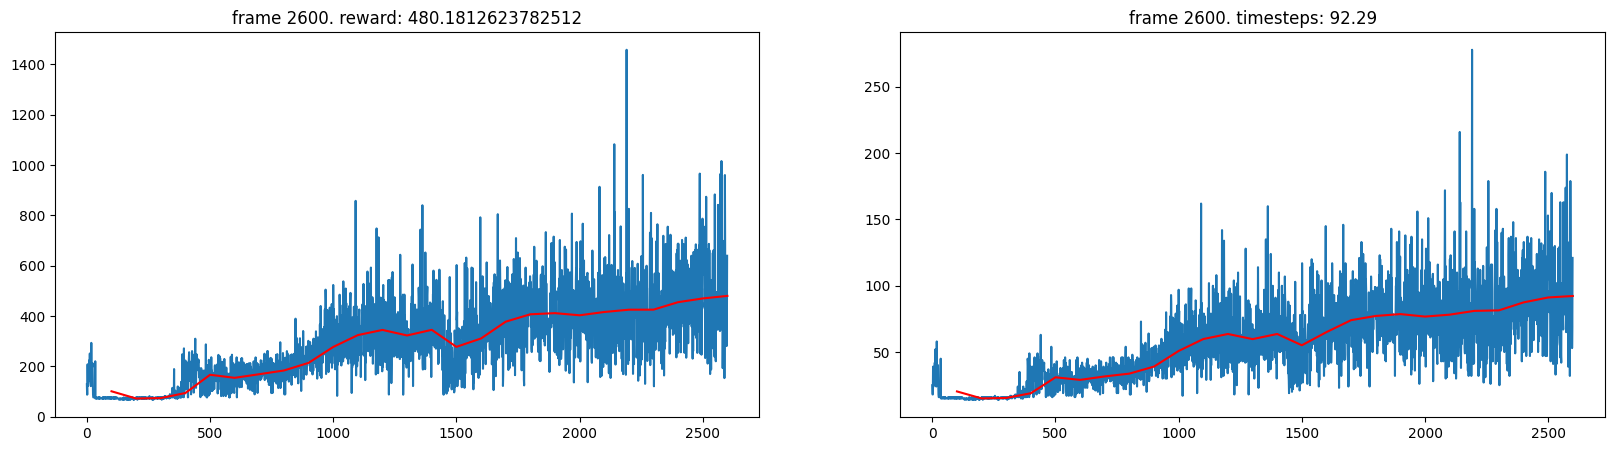

Episode 2600: Total reward = 639.6417923845268
Episode 2601: Total reward = 456.26130047791213
Episode 2602: Total reward = 457.90634886570444
Episode 2603: Total reward = 515.6988687420206
Episode 2604: Total reward = 612.1107284714465
Episode 2605: Total reward = 775.9287695836878
Episode 2606: Total reward = 570.9136109646226
Episode 2607: Total reward = 770.9586662133776
Episode 2608: Total reward = 419.60642502295667
Episode 2609: Total reward = 449.11872274123647
Episode 2610: Total reward = 558.2200564051782
Episode 2611: Total reward = 617.7306966111378
Episode 2612: Total reward = 630.2118817720866
Episode 2613: Total reward = 481.52868705453454
Episode 2614: Total reward = 395.94297672985334
Episode 2615: Total reward = 825.930174373217
Episode 2616: Total reward = 506.59465843554113
Episode 2617: Total reward = 621.1037073025147
Episode 2618: Total reward = 501.6248491222324
Episode 2619: Total reward = 647.0522252449008
Episode 2620: Total reward = 480.71305644657497
Episod

In [47]:
while epoch < max_epochs:
    state, _ = env.reset()
    episode_reward = 0
    running_policy_loss = []
    running_q_loss = []
    for step in range(max_steps):
        # if epoch > 100:
        with torch.no_grad():
          action = noisy_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action.numpy())
        # else:
        #     action = env.action_space.sample()
        #     next_state, reward, terminated, truncated, _ = env.step(action)
        
        done = terminated or truncated
        
        replay_buffer.insert(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        
        if len(replay_buffer) > batch_size:
            update_count+=1
            update(batch_size, GAMMA, TAU)
        
        if done:
            break
    writer.add_scalar("Loss/Actor", np.mean(running_policy_loss), epoch)
    writer.add_scalar("Loss/Critic", np.mean(running_q_loss), epoch)
    writer.add_scalar("Rewards/Train", episode_reward, epoch)
    writer.add_scalar("Timesteps/Train", step+1, epoch)
    running_policy_loss = []
    running_q_loss = []
            
    rewards.append(episode_reward)
    timesteps.append(step+1)
    epoch += 1
    if epoch % 100 == 0:
      plot(epoch, rewards, timesteps)

    curr_mean = np.mean(rewards[-100:])
    if curr_mean >= best:
       best = curr_mean
       torch.save(q_net1.state_dict(), 'Humanoid_DDPG_critic_1.h5')
       torch.save(q_net2.state_dict(), 'Humanoid_DDPG_critic_2.h5')
       torch.save(policy_net1.state_dict(), 'Humanoid_DDPG_actor_1.h5')
       torch.save(policy_net2.state_dict(), 'Humanoid_DDPG_actor_2.h5')

    print(f'Episode {epoch}: Total reward = {episode_reward}')
    if curr_mean >= 500:
       print("Solved.")
       break